# Result Analysis
We use the pickled predictions to run our own analysis and create visualizations.

In [2]:
import pickle
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mmaction.evaluation.metrics.acc_metric import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams.update(
    {
        "font.family": "serif",  # use serif/main font for text elements
        "text.usetex": True,  # use inline math for ticks
        "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    }
)

In [2]:
PREDICTIONS_FILE = "notebooks/predictions.pkl"

with open(PREDICTIONS_FILE, "rb") as f:
    predictions = pickle.load(f)

predictions[:3]

gt_labels = [p["gt_label"] for p in predictions]
pred_labels = [p["pred_label"] for p in predictions]
pred_scores = [p["pred_score"] for p in predictions]
pred_labels[:3], pred_scores[:3]

([tensor([2]), tensor([2]), tensor([2])],
 [tensor([0.0289, 0.0320, 0.9390]),
  tensor([0.0346, 0.0424, 0.9230]),
  tensor([0.0303, 0.0563, 0.9135])])

## Confusion Matrix

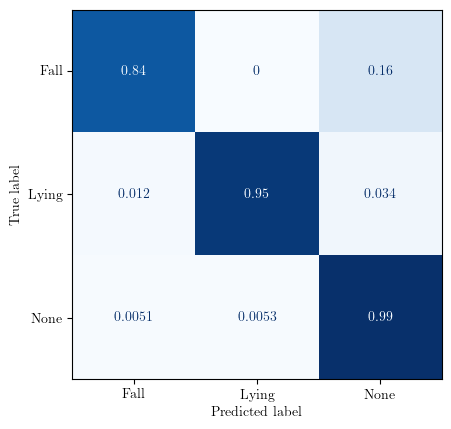

In [3]:
# Create the confusion matrix display
cf = ConfusionMatrixDisplay.from_predictions(
    gt_labels,
    pred_labels,
    normalize="true",
    display_labels=["Fall", "Lying", "None"],
    labels=[0, 1, 2],
    colorbar=False,
    cmap="Blues",
)

# Save the confusion matrix as a LaTeX Tikzplot
cf.figure_.savefig(
    "diagrams/confusion_matrix.pgf", format="pgf", bbox_inches="tight", pad_inches=0
)

# Metrics

In [4]:
from sklearn.metrics import classification_report

print(
    classification_report(
        gt_labels,
        pred_labels,
        target_names=["Fall", "Lying", "Other"],
        output_dict=False,
    )
)

              precision    recall  f1-score   support

        Fall       0.64      0.84      0.73        74
       Lying       0.98      0.95      0.96       983
       Other       0.99      0.99      0.99      4544

    accuracy                           0.98      5601
   macro avg       0.87      0.93      0.89      5601
weighted avg       0.98      0.98      0.98      5601



# Accessing Tensorboard files

In [5]:
from tbparse import SummaryReader
import pickle

experiment_path = Path("experiments/tensorboard/")
dump_path = Path("notebooks/tb_event_reader.pkl")

try:
    reader = pickle.load(open(dump_path, "rb"))
except FileNotFoundError:
    reader = SummaryReader(
        experiment_path, event_types={"scalars"}, extra_columns={"dir_name"}
    )
    pickle.dump(reader, open(dump_path, "wb"))

tb_data = reader.scalars
tb_data = tb_data.rename(
    columns={"tag": "metric", "dir_name": "experiment"},
)


def process_metric_name(metric_name):
    metric_name = metric_name.replace("acc/", "")
    metric_name = metric_name.replace("class_0_", "Fall_")
    metric_name = metric_name.replace("class_1_", "Lying_")
    metric_name = metric_name.replace("class_2_", "Other_")
    return metric_name


tb_data["metric"] = tb_data["metric"].apply(process_metric_name)

METRICS = [
    "Fall_f1",
    "Fall_precision",
    "Fall_recall",
    "Lying_f1",
    "Lying_precision",
    "Lying_recall",
    "Other_f1",
    "Other_precision",
    "Other_recall",
    "unweighted_average_f1",
    "loss",
]

tb_data = tb_data[tb_data["metric"].isin(METRICS)]

EXPERIMENTS = [
    "vit-uniform-sampling_priority-labeling_k400-hyperparams",
    "vit-uniform-sampling_priority-labeling_k400-hyperparams_weighted-ce-loss",
    "vit-b_gaussian-sampling_priority-labeling_k400-hyperparams",
    "vit-b_gaussian-sampling-5s-clips-30-drop_priority-labeling_k400-hyperparams",
    "vit-b_frame-int-8_gaussian-sampling-5s-clips-30-drop_priority-labeling_k400-hyperparams",
]

tb_data = tb_data[tb_data["experiment"].isin(EXPERIMENTS)]
tb_data["experiment_id"] = tb_data["experiment"].apply(
    lambda x: EXPERIMENTS.index(x) + 1
)

tb_data = tb_data.sort_values(by=["experiment_id", "metric", "step"])
tb_data = tb_data.reset_index(drop=True)

tb_data.head()

,step,metric,value,experiment,experiment_id
0,1,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
1,2,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
2,3,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
3,4,Fall_f1,0.0000,vit-uniform-sampling_priority-labeling_k400-hy...,1
4,5,Fall_f1,0.0625,vit-uniform-sampling_priority-labeling_k400-hy...,1


# Loss curves

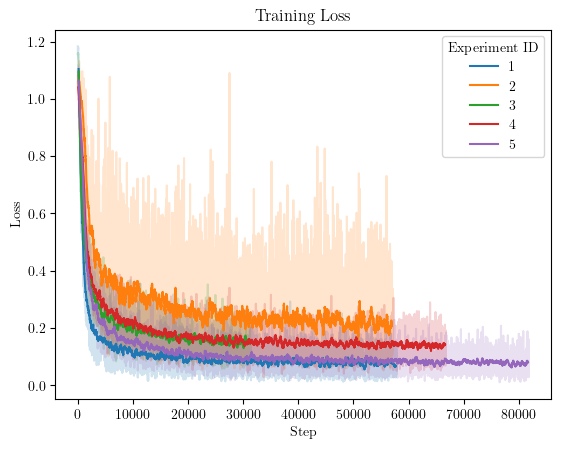

In [6]:
losses = tb_data[tb_data["metric"] == "loss"].copy()

losses["smoothed"] = (
    losses.groupby("experiment_id")["value"]
    .rolling(30, center=True)
    .mean()
    .reset_index(level=0, drop=True)
)
sns.lineplot(
    data=losses,
    x="step",
    y="value",
    hue="experiment_id",
    alpha=0.2,
    legend=False,
    palette="tab10",
)
sns.lineplot(data=losses, x="step", y="smoothed", hue="experiment_id", palette="tab10")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(title="Experiment ID")
plt.savefig("diagrams/loss_curves.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# F1 Curves

In [7]:
f1_scores = tb_data[tb_data["metric"].str.contains("f1")].copy()

## Maximum F1 Scores table

In [8]:
unweighted_average_f1 = f1_scores[f1_scores["metric"] == "unweighted_average_f1"]
max_ids = unweighted_average_f1.groupby(["experiment_id"])["value"].idxmax()
max_f1_steps_index = (
    f1_scores.loc[max_ids][["experiment_id", "step"]]
    .set_index(["experiment_id", "step"])
    .index
)
f1_scores_index = f1_scores.set_index(["experiment_id", "step"]).index
max_f1_scores = f1_scores[f1_scores_index.isin(max_f1_steps_index)]

display(max_f1_scores)

,step,metric,value,experiment,experiment_id
60,61,Fall_f1,0.627451,vit-uniform-sampling_priority-labeling_k400-hy...,1
252,61,Lying_f1,0.903226,vit-uniform-sampling_priority-labeling_k400-hy...,1
444,61,Other_f1,0.978031,vit-uniform-sampling_priority-labeling_k400-hy...,1
6375,61,unweighted_average_f1,0.836236,vit-uniform-sampling_priority-labeling_k400-hy...,1
6409,31,Fall_f1,0.452381,vit-uniform-sampling_priority-labeling_k400-hy...,2
6598,31,Lying_f1,0.907923,vit-uniform-sampling_priority-labeling_k400-hy...,2
6787,31,Other_f1,0.967396,vit-uniform-sampling_priority-labeling_k400-hy...,2
12641,31,unweighted_average_f1,0.775900,vit-uniform-sampling_priority-labeling_k400-hy...,2
12676,9,Fall_f1,0.389610,vit-b_gaussian-sampling_priority-labeling_k400...,3
12760,9,Lying_f1,0.903371,vit-b_gaussian-sampling_priority-labeling_k400...,3


In [9]:
# Pivot the data

pivot_max_f1_scores = max_f1_scores[["metric", "value", "experiment_id"]].pivot(
    values="value", index="experiment_id", columns="metric"
)
print(pivot_max_f1_scores.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
metric & Fall_f1 & Lying_f1 & Other_f1 & unweighted_average_f1 \\
experiment_id &  &  &  &  \\
\midrule
1 & 0.63 & 0.90 & 0.98 & 0.84 \\
2 & 0.45 & 0.91 & 0.97 & 0.78 \\
3 & 0.39 & 0.90 & 0.98 & 0.76 \\
4 & 0.52 & 0.89 & 0.98 & 0.80 \\
5 & 0.74 & 0.92 & 0.98 & 0.88 \\
\bottomrule
\end{tabular}



In [10]:
f1_scores[["experiment_id", "step"]]

,experiment_id,step
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
32413,5,86
32414,5,87
32415,5,88
32416,5,89


# Label Distributions

In [3]:
from datasets import HighQualityFallDataset
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling
from datasets.transforms.label_strategy import PriorityLabel, HQFD_LABEL_DESCRIPTION

train_ann_file = "data/Fall_Simulation_Data/annotations_train.csv"

hqfd_A = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=UniformSampling(clip_len=10),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

hqfd_B = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=GaussianSampling(clip_len=10),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

hqfd_C = HighQualityFallDataset(
    ann_file=train_ann_file,
    sampling_strategy=GaussianSampling(
        clip_len=5, fallback_sampler=UniformSampling(clip_len=5, stride=5)
    ),
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    pipeline=[],
    num_classes=3,
    test_mode=False,
)

datalist_A = pd.DataFrame(hqfd_A.load_data_list())
datalist_A["data_code"] = "A"
datalist_B = pd.DataFrame(hqfd_B.load_data_list())
datalist_B["data_code"] = "B"
datalist_C = pd.DataFrame(hqfd_C.load_data_list())
datalist_C["data_code"] = "C"
datalists = pd.concat([datalist_A, datalist_B, datalist_C])

class_names = ["Fall", "Lying", "Other"]
datalists["label_name"] = datalists["label"].apply(lambda x: class_names[x])


def extract_category(filename):
    match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
    return match.group(1) if match else None


datalists["video_category"] = datalists["filename"].apply(extract_category)
datalists.head()

,filename,label,interval,data_code,label_name,video_category
0,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(0.0, 10.0)",A,Other,Fall
1,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,2,"(10.0, 20.0)",A,Other,Fall
2,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,0,"(20.0, 30.0)",A,Fall,Fall
3,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,0,"(30.0, 40.0)",A,Fall,Fall
4,data/Fall_Simulation_Data/videos/Fall7_Cam4.mp4,1,"(40.0, 50.0)",A,Lying,Fall


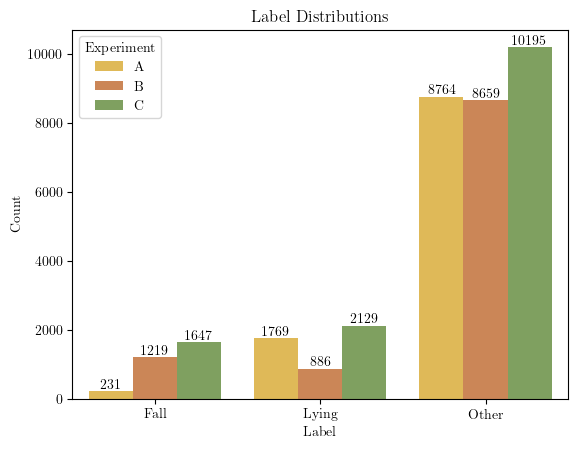

In [5]:
datalists = datalists.sort_values(by=["data_code", "label"])

# Calculate the counts in % of total for each bar
total_counts = (
    datalists.groupby(["label_name", "data_code"]).size().reset_index(name="count")
)
total_counts["percentage"] = (
    total_counts.groupby("data_code")["count"]
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(0, drop=True)
).round(2)


g = sns.barplot(
    data=total_counts,
    x="label_name",
    y="count",
    hue="data_code",
    legend=True,
    palette=["#F5C342", "#DE8344", "#7EAB55"],
)


for i, container in enumerate(g.containers):
    g.bar_label(container)


plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distributions")
g.get_legend().set_title("Experiment")
plt.savefig(
    "diagrams/label_distributions.pdf", format="pdf", bbox_inches="tight", pad_inches=0
)
plt.show()

In [34]:
# Make it a table

total_counts["value"] = total_counts.apply(
    lambda x: f"{x['count']:,} ({(x['percentage']/100):.1%})", axis=1
)

print(
    total_counts.pivot(
        index="label_name", columns="data_code", values="value"
    ).to_latex()
)

\begin{tabular}{llll}
\toprule
data_code & A & B & C \\
label_name &  &  &  \\
\midrule
Fall & 231 (2.1%) & 1,221 (11.3%) & 1,590 (11.4%) \\
Lying & 1,769 (16.4%) & 835 (7.8%) & 2,085 (14.9%) \\
Other & 8,764 (81.4%) & 8,708 (80.9%) & 10,296 (73.7%) \\
\bottomrule
\end{tabular}



TypeError: agg function failed [how->mean,dtype->object]

# Merging results to video level

              precision    recall  f1-score   support

        Fall       0.95      0.96      0.95        55
         ADL       0.88      0.82      0.85        17

    accuracy                           0.93        72
   macro avg       0.91      0.89      0.90        72
weighted avg       0.93      0.93      0.93        72



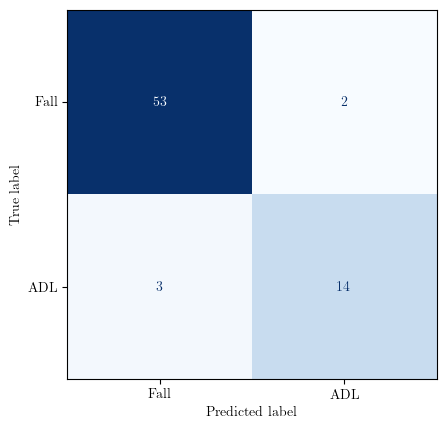

In [35]:
from datasets import HighQualityFallDataset
from datasets.transforms.sampling_strategy import GaussianSampling, UniformSampling
from datasets.transforms.label_strategy import PriorityLabel, HQFD_LABEL_DESCRIPTION

test_ann_file = "data/Fall_Simulation_Data/annotations_test.csv"

hqfd_test = HighQualityFallDataset(
    label_strategy=PriorityLabel(HQFD_LABEL_DESCRIPTION),
    ann_file=test_ann_file,
    num_classes=3,
    pipeline=[],
    test_mode=True,
    sampling_strategy=UniformSampling(clip_len=5, overlap=False, stride=0),
)

datalist_test = pd.DataFrame(hqfd_test.load_data_list())
datalist_test["prediction"] = pd.Series(pred_labels).astype(int)


def extract_category(filename):
    match = re.search(r"(ADL|Fall)", filename.split("/")[-1])
    return match.group(1) if match else None


datalist_test["video_category"] = datalist_test["filename"].apply(extract_category)

class_map = {
    "Fall": 0,
    "ADL": 2,
}

datalist_test["video_label"] = datalist_test["video_category"].replace(class_map)


video_level_predictions = pd.DataFrame(
    datalist_test.groupby("filename")["prediction"].min()
)
video_level_predictions["prediction"] = video_level_predictions["prediction"].replace(
    {1: 2}
)

video_level_predictions["video_label"] = datalist_test.groupby("filename")[
    "video_label"
].first()

print(
    classification_report(
        video_level_predictions["video_label"],
        video_level_predictions["prediction"],
        labels=[0, 2],
        target_names=["Fall", "ADL"],
        output_dict=False,
    )
)

cf = ConfusionMatrixDisplay.from_predictions(
    video_level_predictions["video_label"],
    video_level_predictions["prediction"],
    display_labels=["Fall", "ADL"],
    labels=[0, 2],
    colorbar=False,
    cmap="Blues",
)

# Video-level IOU calculation

In [44]:
annotations = pd.read_csv("data/Fall_Simulation_Data/annotations_test.csv")
annotations["fall_interval"] = annotations.apply(
    lambda x: (x["fall_start"], x["fall_end"]), axis=1
)

annotations = annotations[["video_path", "fall_interval"]]

annotations

,video_path,fall_interval
0,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,"(128.0, 131.0)"
1,data/Fall_Simulation_Data/videos/Fall13_Cam3.mp4,"(24.0, 27.0)"
2,data/Fall_Simulation_Data/videos/Fall1_Cam1.mp4,"(47.0, 50.0)"
3,data/Fall_Simulation_Data/videos/Fall45_Cam2.mp4,"(20.0, 22.0)"
4,data/Fall_Simulation_Data/videos/ADL10_Cam3.mp4,"(nan, nan)"
...,...,...
67,data/Fall_Simulation_Data/videos/ADL5_Cam2.mp4,"(nan, nan)"
68,data/Fall_Simulation_Data/videos/Fall47_Cam4.mp4,"(25.0, 28.0)"
69,data/Fall_Simulation_Data/videos/Fall38_Cam4.mp4,"(24.0, 26.0)"
70,data/Fall_Simulation_Data/videos/ADL16_Cam1.mp4,"(nan, nan)"


In [49]:
group_test = datalist_test.groupby("filename").get_group(
    "data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4"
)

group_test

,filename,label,interval,prediction,video_category,video_label
0,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(0.0, 5.0)",2,Fall,0
1,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(5.0, 10.0)",2,Fall,0
2,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(10.0, 15.0)",2,Fall,0
3,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(15.0, 20.0)",2,Fall,0
4,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(20.0, 25.0)",2,Fall,0
5,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(25.0, 30.0)",2,Fall,0
6,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(30.0, 35.0)",2,Fall,0
7,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(35.0, 40.0)",2,Fall,0
8,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(40.0, 45.0)",2,Fall,0
9,data/Fall_Simulation_Data/videos/Fall3_Cam2.mp4,2,"(45.0, 50.0)",2,Fall,0
